# Transforming intent
# ===================
# 




## Load libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import json

In [2]:
from sklearn.pipeline import make_pipeline, Pipeline

import numpy as np
from sklearn.naive_bayes import ComplementNB
from sklearn.svm import SVC

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import learning_curve
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, f1_score




In [3]:
import torch

import datasets
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from transformers import Trainer, TrainingArguments



In [4]:
torch.backends.mps.is_available()

True

In [5]:
device = torch.device("mps")  #("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
import sys

In [7]:
sys.version

'3.9.7 | packaged by conda-forge | (default, Sep 29 2021, 19:24:02) \n[Clang 11.1.0 ]'

In [8]:
pd.options.display.max_rows = 2000

In [9]:
try:
    %load_ext autotime
except:
    !pip install ipython-autotime
    %load_ext autotime

time: 292 µs (started: 2023-01-24 14:48:14 -05:00)


## Load data

In [10]:
!ls -l ./data

total 2120
-rw-r--r--  1 szalmaf  staff    2036 Jan 17 12:39 categories.json
-rw-r--r--  1 szalmaf  staff  239961 Jan 17 12:39 test.csv
-rw-r--r--  1 szalmaf  staff  839073 Jan 17 12:39 train.csv
time: 141 ms (started: 2023-01-24 14:48:14 -05:00)


In [11]:
drctry = r'./data/'
df_train = pd.read_csv(drctry + 'train.csv')
df_test = pd.read_csv(drctry + 'test.csv')

time: 19.1 ms (started: 2023-01-24 14:48:14 -05:00)


In [12]:
df_train

text         category
0                         I am still waiting on my card?     card_arrival
1      What can I do if my card still hasn't arrived ...     card_arrival
2      I have been waiting over a week. Is the card s...     card_arrival
3      Can I track my card while it is in the process...     card_arrival
4      How do I know if I will get my card, or if it ...     card_arrival
...                                                  ...              ...
9998              You provide support in what countries?  country_support
9999                  What countries are you supporting?  country_support
10000                What countries are getting support?  country_support
10001                     Are cards available in the EU?  country_support
10002                   Which countries are represented?  country_support

[10003 rows x 2 columns]

time: 12.4 ms (started: 2023-01-24 14:48:14 -05:00)


In [13]:
df_test

text         category
0                              How do I locate my card?     card_arrival
1     I still have not received my new card, I order...     card_arrival
2     I ordered a card but it has not arrived. Help ...     card_arrival
3      Is there a way to know when my card will arrive?     card_arrival
4                          My card has not arrived yet.     card_arrival
...                                                 ...              ...
3075      If i'm not in the UK, can I still get a card?  country_support
3076                 How many countries do you support?  country_support
3077              What countries do you do business in?  country_support
3078             What are the countries you operate in.  country_support
3079         Can the card be mailed and used in Europe?  country_support

[3080 rows x 2 columns]

time: 11.4 ms (started: 2023-01-24 14:48:14 -05:00)


In [14]:
df_all = df_train.append(df_test, ignore_index=True)
# df_train['category'].unique()
df_all

/var/folders/sg/jbxm9pmx5mnczp012lfll6y80000gn/T/ipykernel_27461/3699321675.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all = df_train.append(df_test, ignore_index=True)


text         category
0                         I am still waiting on my card?     card_arrival
1      What can I do if my card still hasn't arrived ...     card_arrival
2      I have been waiting over a week. Is the card s...     card_arrival
3      Can I track my card while it is in the process...     card_arrival
4      How do I know if I will get my card, or if it ...     card_arrival
...                                                  ...              ...
13078      If i'm not in the UK, can I still get a card?  country_support
13079                 How many countries do you support?  country_support
13080              What countries do you do business in?  country_support
13081             What are the countries you operate in.  country_support
13082         Can the card be mailed and used in Europe?  country_support

[13083 rows x 2 columns]

time: 13.9 ms (started: 2023-01-24 14:48:14 -05:00)


### Basic stats of dataset

#### Intent distribution

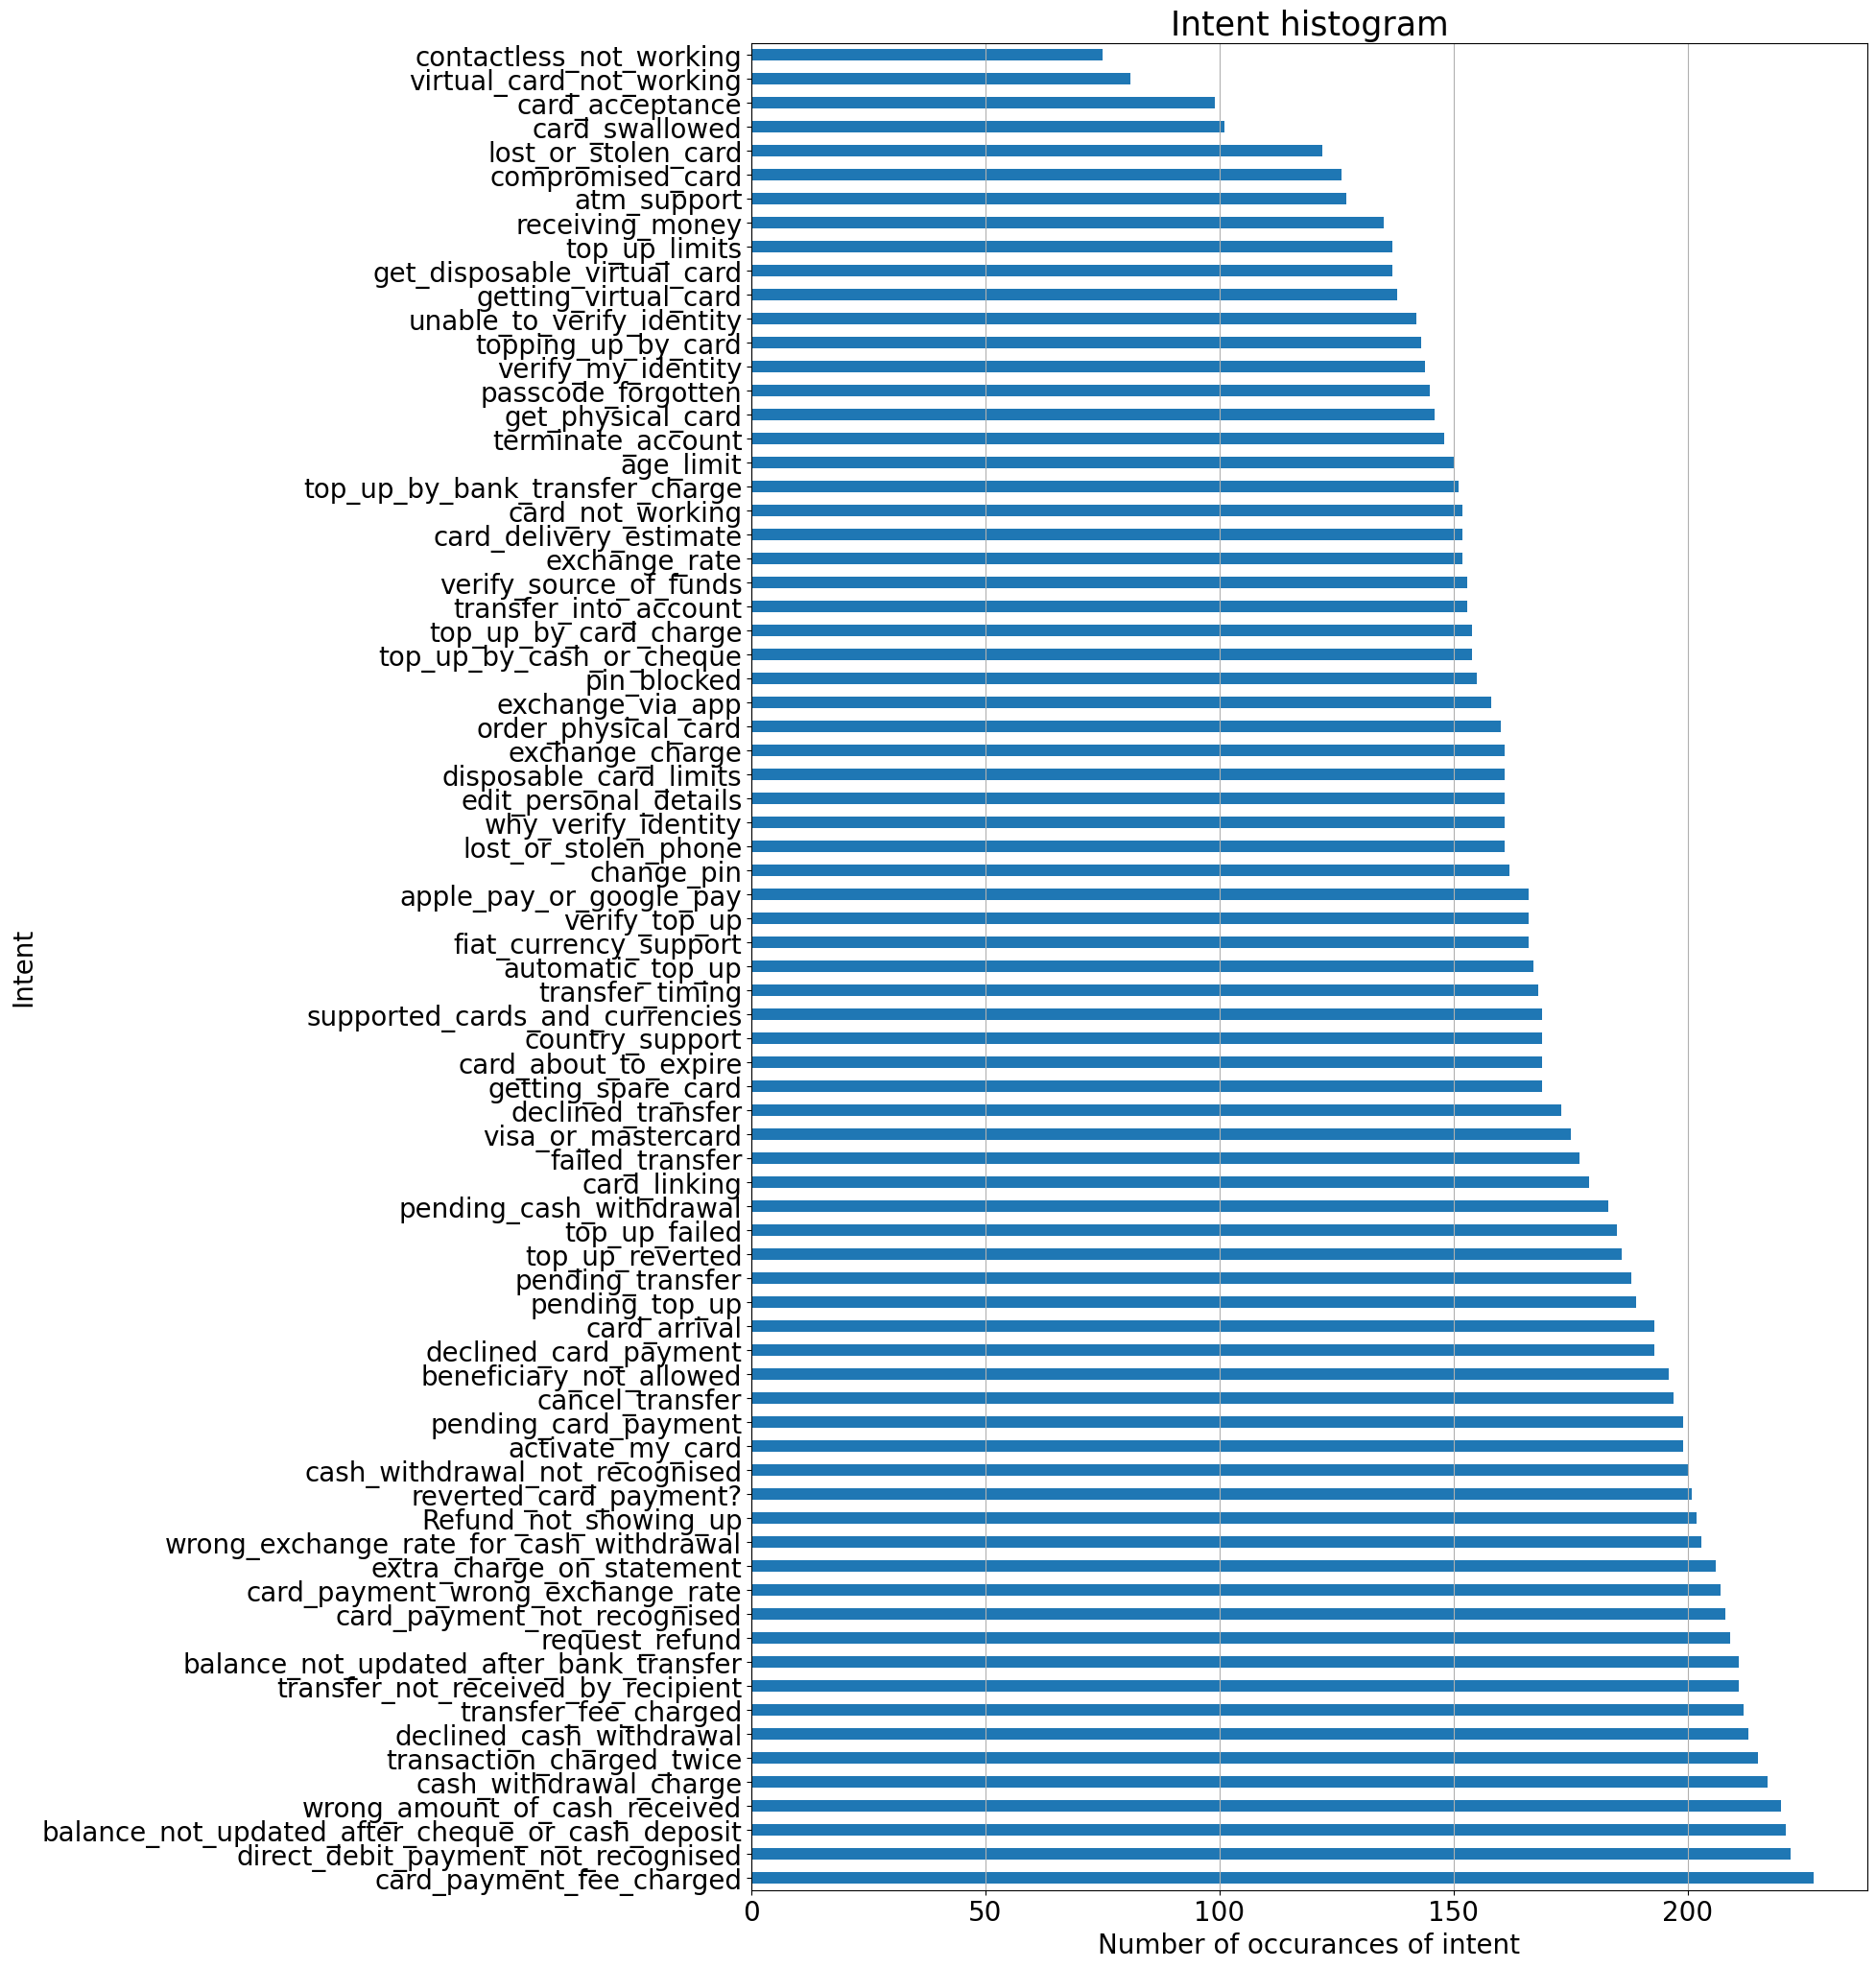

time: 752 ms (started: 2023-01-24 14:48:15 -05:00)


In [15]:
# Subintent distribution
ax = df_all['category'].value_counts(normalize=False).plot.barh(figsize=(15,25))
ax.set_title('Intent histogram', fontsize=25)
ax.set_xlabel('Number of occurances of intent', fontsize=20)
ax.set_ylabel('Intent', fontsize=20)

plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.grid(axis='x')

In [16]:
pd.DataFrame(pd.Series([item for item in df_all["category"]]).value_counts(normalize=False))

0
card_payment_fee_charged                          227
direct_debit_payment_not_recognised               222
balance_not_updated_after_cheque_or_cash_deposit  221
wrong_amount_of_cash_received                     220
cash_withdrawal_charge                            217
transaction_charged_twice                         215
declined_cash_withdrawal                          213
transfer_fee_charged                              212
transfer_not_received_by_recipient                211
balance_not_updated_after_bank_transfer           211
request_refund                                    209
card_payment_not_recognised                       208
card_payment_wrong_exchange_rate                  207
extra_charge_on_statement                         206
wrong_exchange_rate_for_cash_withdrawal           203
Refund_not_showing_up                             202
reverted_card_payment?                            201
cash_withdrawal_not_recognised                    200
activate_my_card                                  199
pending_card_payment                              199
cancel_transfer                                   197
beneficiary_not_allowed                           196
declined_card_payment                             193
card_arrival                                      193
pending_top_up                                    189
pending_transfer                                  188
top_up_reverted                                   186
top_up_failed                                     185
pending_cash_withdrawal                           183
card_linking                                      179
failed_transfer                                   177
visa_or_mastercard                                175
declined_transfer                                 173
getting_spare_card                                169
card_about_to_expire                              169
country_support                                   169
supported_cards_and_currencies                    169
transfer_timing                                   168
automatic_top_up                                  167
fiat_currency_support                             166
verify_top_up                                     166
apple_pay_or_google_pay                           166
change_pin                                        162
lost_or_stolen_phone                              161
why_verify_identity                               161
edit_personal_details                             161
disposable_card_limits                            161
exchange_charge                                   161
order_physical_card                               160
exchange_via_app                                  158
pin_blocked                                       155
top_up_by_cash_or_cheque                          154
top_up_by_card_charge                             154
transfer_into_account                             153
verify_source_of_funds                            153
exchange_rate                                     152
card_delivery_estimate                            152
card_not_working                                  152
top_up_by_bank_transfer_charge                    151
age_limit                                         150
terminate_account                                 148
get_physical_card                                 146
passcode_forgotten                                145
verify_my_identity                                144
topping_up_by_card                                143
unable_to_verify_identity                         142
getting_virtual_card                              138
get_disposable_virtual_card                       137
top_up_limits                                     137
receiving_money                                   135
atm_support                                       127
compromised_card                                  126
lost_or_stolen_card                               122
card_swallowed                                    101
ca

time: 4.8 ms (started: 2023-01-24 14:48:15 -05:00)


## Word vectors

### Tf-idf (term frequncy inverse document frequency) word vectors

#### 10003 utterances, vocabulary of 2320 words

In [17]:
cntvectzr = CountVectorizer()
data_counts = cntvectzr.fit_transform(df_all['text'])
data_counts.shape

(13083, 2532)

time: 64.7 ms (started: 2023-01-24 14:48:15 -05:00)


In [18]:
data_tfidf = TfidfTransformer().fit_transform(data_counts)
data_tfidf.shape

(13083, 2532)

time: 5.94 ms (started: 2023-01-24 14:48:15 -05:00)


In [19]:
pd.DataFrame(data_tfidf.toarray().T, index=cntvectzr.get_feature_names_out())

0      1      2      3      4      5      6      7      8      \
00          0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
000         0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
10          0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
100         0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
12          0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
...         ...    ...    ...    ...    ...    ...    ...    ...    ...   
youngest    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
your        0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
youre       0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
yours       0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
zero        0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   

          9      ...  13073  13074  13075  13076  13077  13078  13079  13080  \
00          0.0  ...    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
000         0.0  ...    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
10          0.0  ...    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
100         0.0  ...    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
12          0.0  ...    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
...         ...  ...    ...    ...    ...    ...    ...    ...    ...    ...   
youngest    0.0  ...    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
your        0.0  ...    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
youre       0.0  ...    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
yours       0.0  ...    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
zero        0.0  ...    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   

          13081  13082  
00          0.0    0.0  
000         0.0    0.0  
10          0.0    0.0  
100         0.0    0.0  
12          0.0    0.0  
...         ...    ...  
youngest    0.0    0.0  
your        0.0    0.0  
youre       0.0    0.0  
yours       0.0    0.0  
zero        0.0    0.0  

[2532 rows x 13083 columns]

time: 32.9 ms (started: 2023-01-24 14:48:15 -05:00)


## Naive Bayes model

### Model pipeline

In [20]:
model_NB = make_pipeline(
                CountVectorizer(),
                TfidfTransformer(),
                ComplementNB())  #force_alpha=True))

time: 228 µs (started: 2023-01-24 14:48:15 -05:00)


### Learning curve

In [21]:
train_sizes = np.logspace(np.log(0.2), np.log(1.0), num=20, endpoint=True)  # np.linspace(0.1, 1.0, num=10, endpoint=True)

time: 279 µs (started: 2023-01-24 14:48:16 -05:00)


In [22]:
cv = KFold(n_splits=5, shuffle=True, random_state=42)

time: 812 µs (started: 2023-01-24 14:48:16 -05:00)


In [23]:
results = learning_curve(estimator = model_NB,
                         X = df_all['text'],
                         y = df_all['category'],
                         train_sizes = train_sizes,
                         cv = cv,
                         scoring ='f1_macro')
train_size, train_scores, test_scores = results[:3]

time: 6.34 s (started: 2023-01-24 14:48:16 -05:00)


In [24]:
train_size

array([  257,   312,   379,   461,   561,   682,   829,  1007,  1224,
        1488,  1808,  2198,  2671,  3247,  3946,  4796,  5829,  7085,
        8611, 10466])

time: 992 µs (started: 2023-01-24 14:48:22 -05:00)


In [25]:
train_scores, test_scores

(array([[0.98700729, 0.98911546, 0.97534603, 0.9870904 , 0.98579972],
        [0.99068462, 0.98911546, 0.98501841, 0.98782314, 0.99076878],
        [0.99311154, 0.9855896 , 0.98533144, 0.99106459, 0.9896151 ],
        [0.98876519, 0.9850012 , 0.97735727, 0.9774814 , 0.98642718],
        [0.98517622, 0.98595187, 0.97416586, 0.98055359, 0.98193066],
        [0.98480018, 0.98302824, 0.97738063, 0.98398081, 0.98512359],
        [0.96353593, 0.95928015, 0.96430138, 0.95058499, 0.9587175 ],
        [0.96777866, 0.97281456, 0.96724914, 0.96111055, 0.96604044],
        [0.95426608, 0.95861848, 0.95373232, 0.95748269, 0.96168004],
        [0.95896109, 0.95592043, 0.95271572, 0.95588848, 0.95549597],
        [0.93406178, 0.93608631, 0.92990634, 0.94313698, 0.93958198],
        [0.93260118, 0.93399783, 0.93560219, 0.93482835, 0.92693543],
        [0.91927394, 0.91870707, 0.91734451, 0.91988749, 0.91766305],
        [0.91397677, 0.89516486, 0.89492436, 0.91274578, 0.8941652 ],
        [0.8817889 ,

time: 1.77 ms (started: 2023-01-24 14:48:22 -05:00)


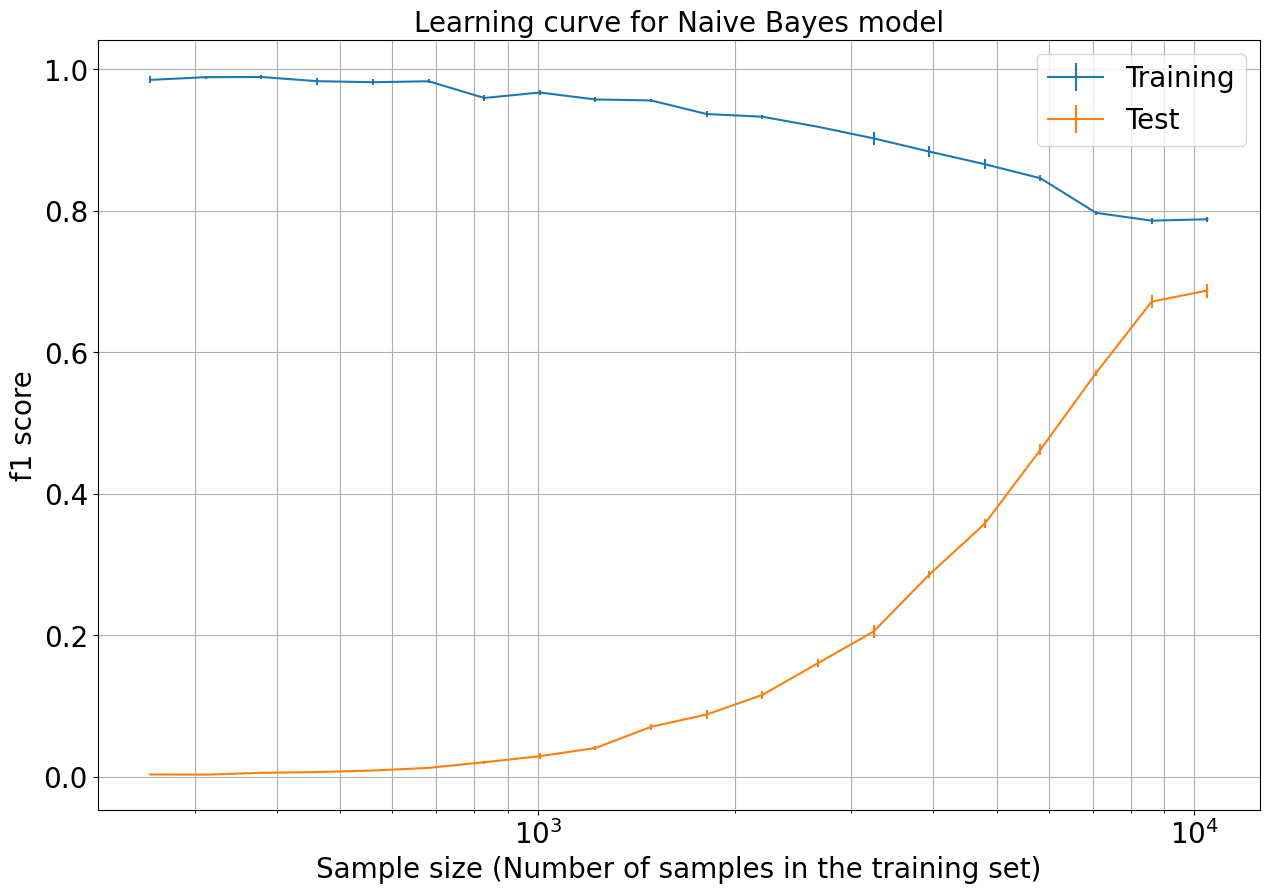

time: 237 ms (started: 2023-01-24 14:48:22 -05:00)


In [26]:
fig, ax = plt.subplots(figsize=(15, 10))

plt.errorbar(train_size, train_scores.mean(axis=1),
             yerr=train_scores.std(axis=1), label="Training")
plt.errorbar(train_size, test_scores.mean(axis=1),
             yerr=test_scores.std(axis=1), label="Test")

plt.title("Learning curve for Naive Bayes model", fontsize=20)
plt.legend(fontsize=20)
plt.xscale("log")
plt.xlabel("Sample size (Number of samples in the training set)", fontsize=20)
plt.xticks(fontsize=20)
plt.ylabel("f1 score", fontsize=20)
plt.yticks(fontsize=20)

plt.grid(which='both')

### Classification report

In [27]:
lbl_names = pd.Series([item for item in df_train['category']]).value_counts(normalize=False).index.values  # Descending order
lbl_names

array(['card_payment_fee_charged', 'direct_debit_payment_not_recognised',
       'balance_not_updated_after_cheque_or_cash_deposit',
       'wrong_amount_of_cash_received', 'cash_withdrawal_charge',
       'transaction_charged_twice', 'declined_cash_withdrawal',
       'transfer_fee_charged', 'transfer_not_received_by_recipient',
       'balance_not_updated_after_bank_transfer', 'request_refund',
       'card_payment_not_recognised', 'card_payment_wrong_exchange_rate',
       'extra_charge_on_statement',
       'wrong_exchange_rate_for_cash_withdrawal', 'Refund_not_showing_up',
       'reverted_card_payment?', 'cash_withdrawal_not_recognised',
       'activate_my_card', 'pending_card_payment', 'cancel_transfer',
       'beneficiary_not_allowed', 'declined_card_payment', 'card_arrival',
       'pending_top_up', 'pending_transfer', 'top_up_reverted',
       'top_up_failed', 'pending_cash_withdrawal', 'card_linking',
       'failed_transfer', 'visa_or_mastercard', 'declined_transfer',
   

time: 2.63 ms (started: 2023-01-24 14:48:22 -05:00)


In [28]:
# Learn the intents on the training set
model_NB.fit(df_train['text'], df_train['category'])

# Predict the intent on the test set
y_pred = model_NB.predict(df_test['text'])

time: 92.8 ms (started: 2023-01-24 14:48:22 -05:00)


In [29]:
report = classification_report(df_test['category'], y_pred, labels=lbl_names)
print(f"Classification report for Naive Bayes classifier:\n"
      f"{report}\n")

Classification report for Naive Bayes classifier:
                                                  precision    recall  f1-score   support

                        card_payment_fee_charged       0.53      0.72      0.61        40
             direct_debit_payment_not_recognised       0.81      0.88      0.84        40
balance_not_updated_after_cheque_or_cash_deposit       0.73      0.88      0.80        40
                   wrong_amount_of_cash_received       0.62      0.90      0.73        40
                          cash_withdrawal_charge       0.78      0.70      0.74        40
                       transaction_charged_twice       0.70      1.00      0.82        40
                        declined_cash_withdrawal       0.45      0.38      0.41        40
                            transfer_fee_charged       0.62      0.45      0.52        40
              transfer_not_received_by_recipient       0.57      0.68      0.62        40
         balance_not_updated_after_bank_transfer 

### Confusion matrix

In [30]:
cm = confusion_matrix(y_true=df_test['category'], y_pred=y_pred, labels=lbl_names)

time: 4.02 ms (started: 2023-01-24 14:48:23 -05:00)


In [31]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=lbl_names)

time: 200 µs (started: 2023-01-24 14:48:23 -05:00)


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
        68, 69, 70, 71, 72, 73, 74, 75, 76]),
 [Text(0, 0, 'card_payment_fee_charged'),
  Text(1, 0, 'direct_debit_payment_not_recognised'),
  Text(2, 0, 'balance_not_updated_after_cheque_or_cash_deposit'),
  Text(3, 0, 'wrong_amount_of_cash_received'),
  Text(4, 0, 'cash_withdrawal_charge'),
  Text(5, 0, 'transaction_charged_twice'),
  Text(6, 0, 'declined_cash_withdrawal'),
  Text(7, 0, 'transfer_fee_charged'),
  Text(8, 0, 'transfer_not_received_by_recipient'),
  Text(9, 0, 'balance_not_updated_after_bank_transfer'),
  Text(10, 0, 'request_refund'),
  Text(11, 0, 'card_payment_not_recognised'),
  Text(12, 0, 'card_payment_wrong_exchange_rate'),
  Text(13, 0, 'extra_charge_on_statement

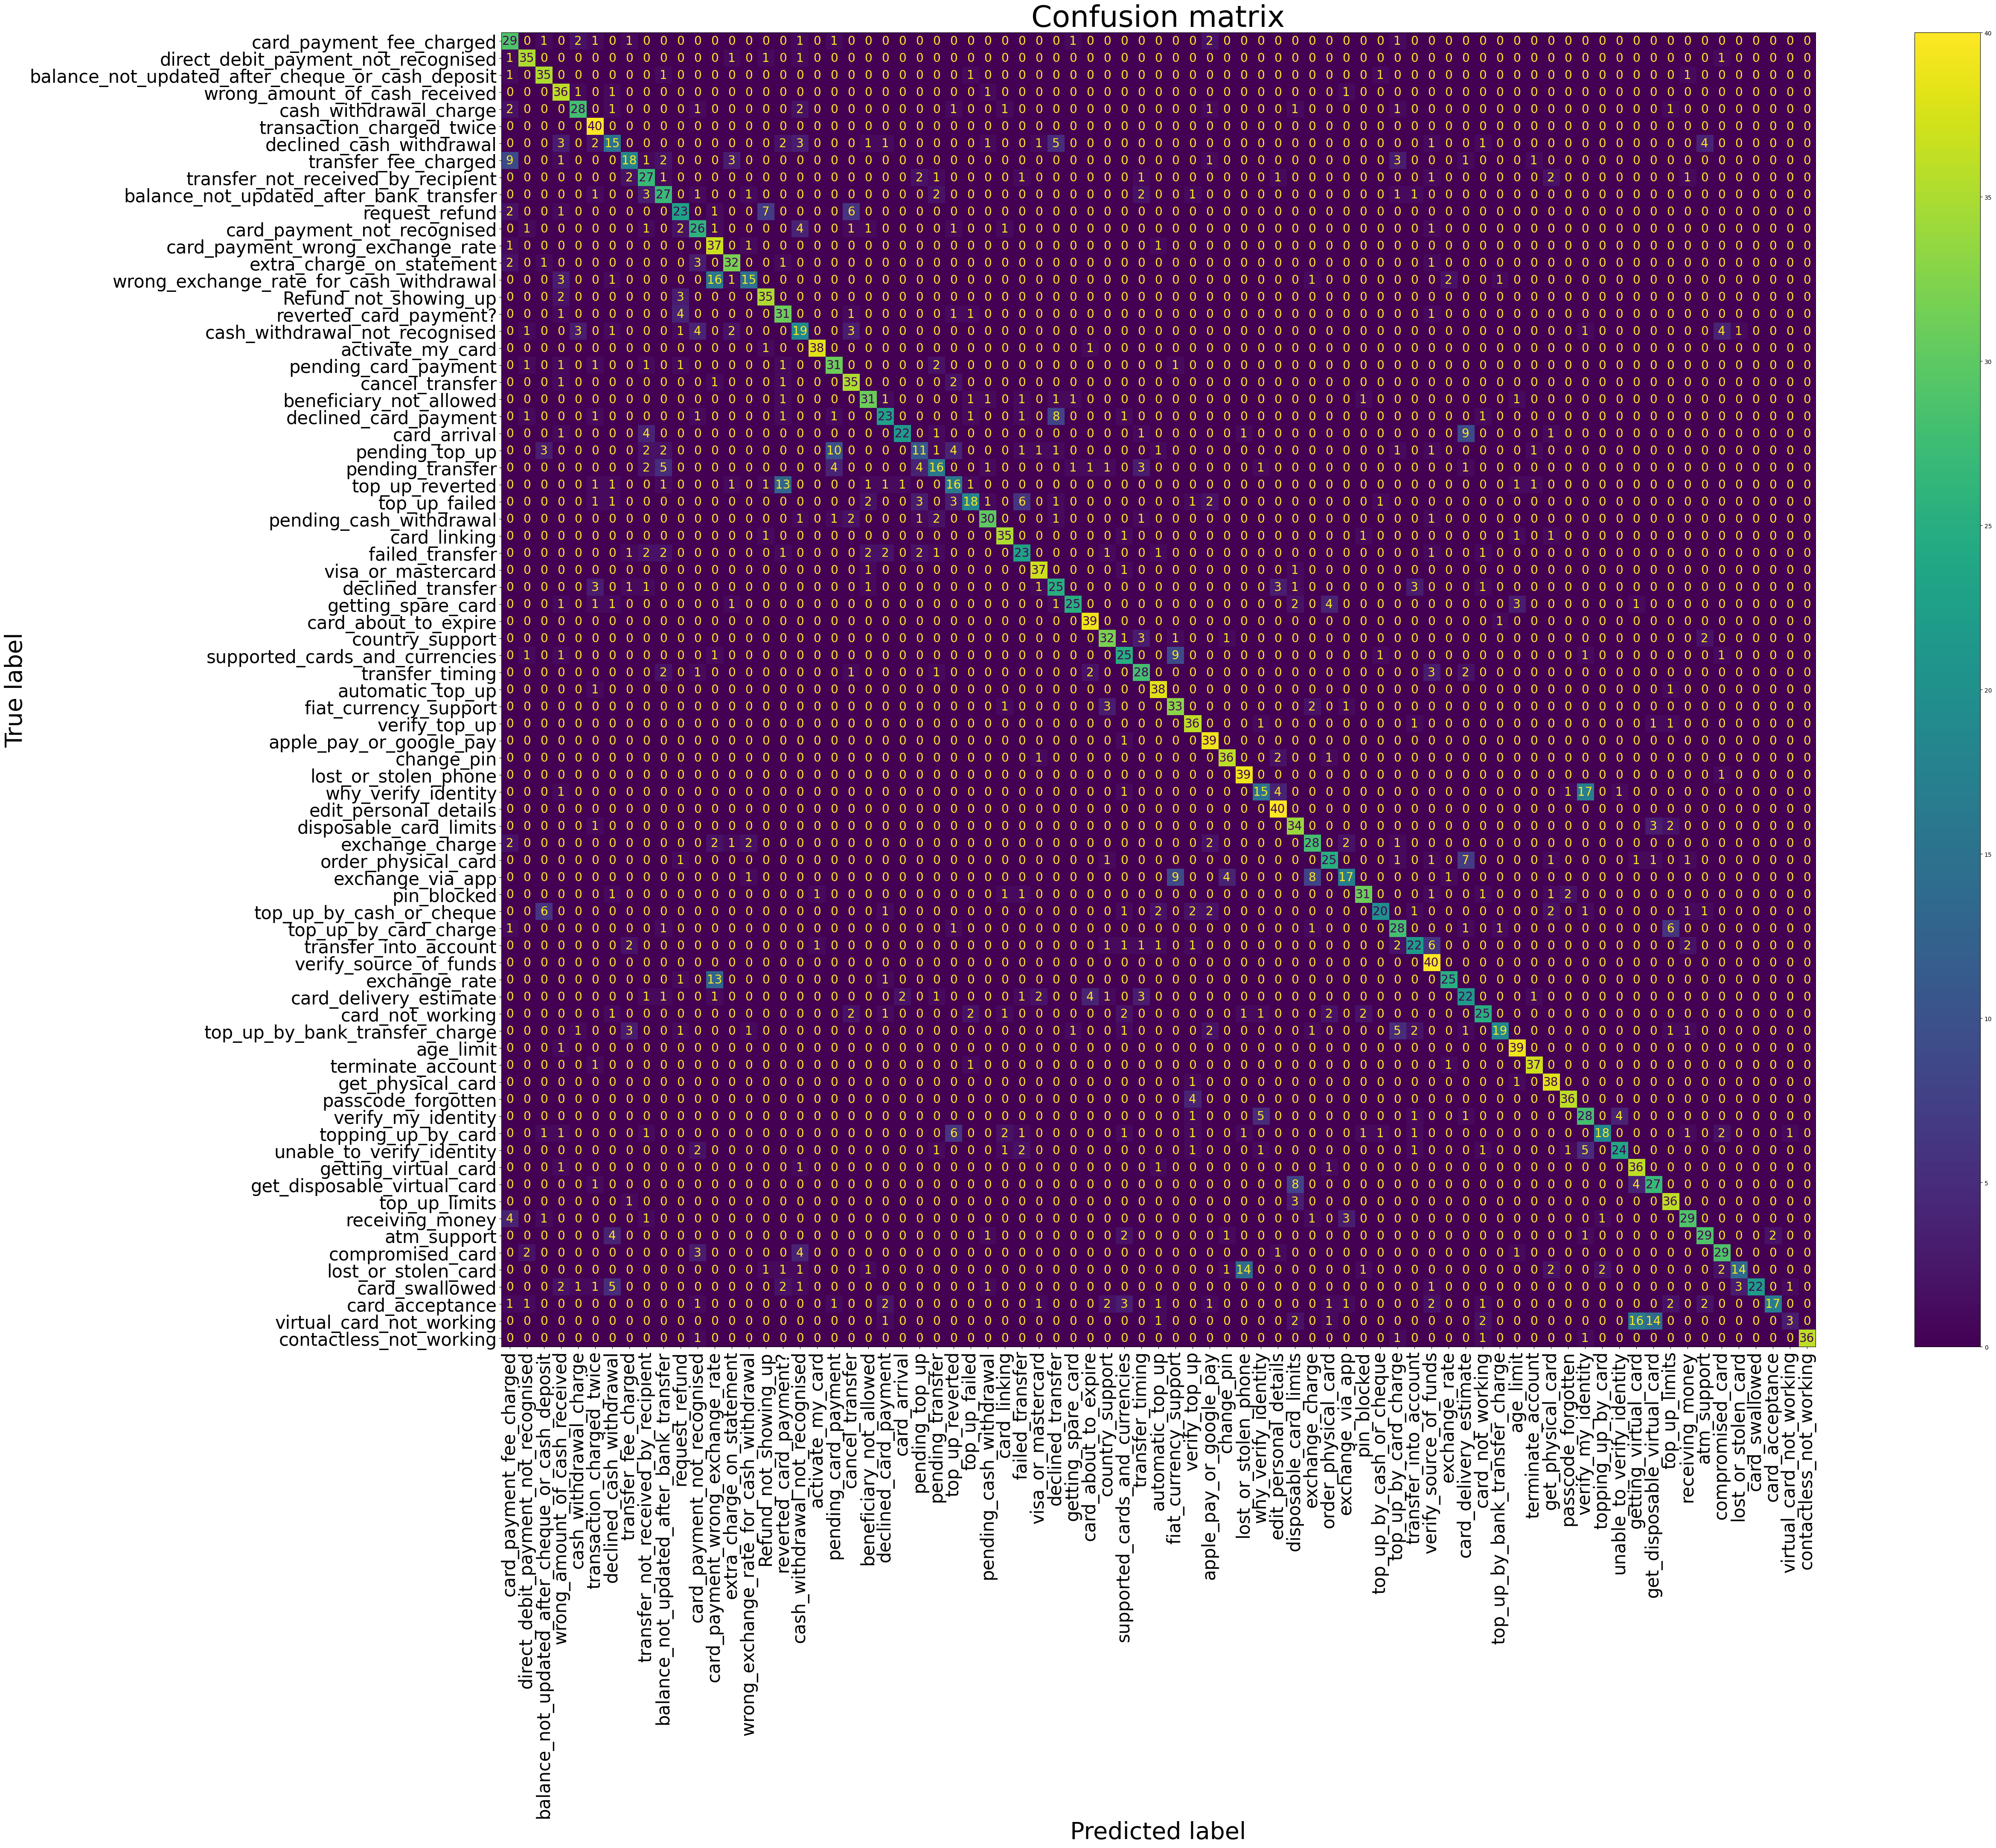

time: 5.48 s (started: 2023-01-24 14:48:23 -05:00)


In [32]:
fig, ax = plt.subplots(figsize=(60, 40))
disp.plot(ax=ax, xticks_rotation='vertical')

for labels in disp.text_.ravel():
    labels.set_fontsize(20)

ax.set_title('Confusion matrix', fontsize=50)
ax.set_ylabel('True label', fontsize=40)
ax.set_xlabel('Predicted label', fontsize=40)

plt.yticks(fontsize=30)
plt.xticks(fontsize=30)

### Analysis of confusion matrix

Note, for example, that *virtual_card_not_working* gets confused by the Naive Bayes algorithm by *get_virtual_card* and *get_disposable_virtual_card*. Apparently, the word *virtual* confuses the algorithm.

Similarly, *lost_or_stolen_card* gets confused by *lost_or_stolen_phone*.

## Transformer model

### From Pandas dataframes to datasets

In [33]:
ds = datasets.Dataset.from_pandas(df_all)

time: 3.69 ms (started: 2023-01-24 14:48:28 -05:00)


In [34]:
ds

Dataset({
    features: ['text', 'category'],
    num_rows: 13083
})

time: 745 µs (started: 2023-01-24 14:48:28 -05:00)


In [35]:
dst = ds.train_test_split(test_size=0.2, seed=42)

time: 2.88 ms (started: 2023-01-24 14:48:28 -05:00)


In [36]:
dst

DatasetDict({
    train: Dataset({
        features: ['text', 'category'],
        num_rows: 10466
    })
    test: Dataset({
        features: ['text', 'category'],
        num_rows: 2617
    })
})

time: 4.81 ms (started: 2023-01-24 14:48:29 -05:00)


In [37]:
dst['train'].features

{'text': Value(dtype='string', id=None),
 'category': Value(dtype='string', id=None)}

time: 6.99 ms (started: 2023-01-24 14:48:32 -05:00)


### Tokenize utterances

Load the default subword tokenizer for the model.

In [38]:
model_ckpt = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

time: 268 ms (started: 2023-01-24 14:48:34 -05:00)


In [39]:
text = "She walks in beauty, like the night of cloudless climes and starry skies;"
tokenized_text = tokenizer(text)
print(tokenized_text)

{'input_ids': [101, 2016, 7365, 1999, 5053, 1010, 2066, 1996, 2305, 1997, 6112, 3238, 18856, 14428, 2015, 1998, 14330, 2100, 15717, 1025, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}
time: 785 µs (started: 2023-01-24 14:48:34 -05:00)


In [40]:
tokens = tokenizer.convert_ids_to_tokens(tokenized_text.input_ids)
print(tokens)

['[CLS]', 'she', 'walks', 'in', 'beauty', ',', 'like', 'the', 'night', 'of', 'cloud', '##less', 'cl', '##ime', '##s', 'and', 'starr', '##y', 'skies', ';', '[SEP]']
time: 1.28 ms (started: 2023-01-24 14:48:35 -05:00)


In [41]:
print(tokenizer.convert_tokens_to_string(tokens))

[CLS] she walks in beauty, like the night of cloudless climes and starry skies ; [SEP]
time: 917 µs (started: 2023-01-24 14:48:35 -05:00)


In [42]:
tokenizer.vocab_size

30522

time: 4.77 ms (started: 2023-01-24 14:48:35 -05:00)


In [43]:
tokenizer.model_max_length

512

time: 5.12 ms (started: 2023-01-24 14:48:36 -05:00)


In [44]:
dst['train']['text'][:5]

['Why was the transfer declined?',
 'Help me activate my card.',
 'How do disposable cards work?',
 'I cannot use my card.',
 'I tried to top up but the app rejected it.']

time: 34.3 ms (started: 2023-01-24 14:48:36 -05:00)


In [45]:
dst['train']['category'][:5]

['declined_transfer',
 'activate_my_card',
 'get_disposable_virtual_card',
 'card_not_working',
 'top_up_failed']

time: 33.9 ms (started: 2023-01-24 14:48:37 -05:00)


In [46]:
def tokenize(batch):
    tokens = tokenizer(batch['text'], padding=True, truncation=True)
    tokens['labels'] = labels.str2int(batch['category'])
    return tokens

time: 809 µs (started: 2023-01-24 14:48:37 -05:00)


In [47]:
from datasets import ClassLabel

lbl_names = pd.Series([item for item in dst['train']["category"]]).value_counts(normalize=False).index.values  # Descending order
labels = ClassLabel(names=lbl_names)
labels.num_classes
labels.names

array(['card_payment_fee_charged', 'cash_withdrawal_charge',
       'wrong_amount_of_cash_received',
       'balance_not_updated_after_cheque_or_cash_deposit',
       'balance_not_updated_after_bank_transfer',
       'direct_debit_payment_not_recognised', 'transfer_fee_charged',
       'transaction_charged_twice', 'request_refund',
       'card_payment_not_recognised', 'declined_cash_withdrawal',
       'declined_card_payment', 'card_payment_wrong_exchange_rate',
       'reverted_card_payment?', 'extra_charge_on_statement',
       'card_arrival', 'transfer_not_received_by_recipient',
       'Refund_not_showing_up', 'activate_my_card',
       'wrong_exchange_rate_for_cash_withdrawal',
       'cash_withdrawal_not_recognised', 'cancel_transfer',
       'beneficiary_not_allowed', 'pending_card_payment',
       'pending_transfer', 'top_up_failed', 'card_linking',
       'top_up_reverted', 'verify_top_up', 'pending_cash_withdrawal',
       'supported_cards_and_currencies', 'pending_top_up',


time: 32.6 ms (started: 2023-01-24 14:48:38 -05:00)


Apply the tokenize method to the whole dataset in one shot, hence the batch_size=None.

In [48]:
dst_tokenized = dst.map(tokenize, batched=True, batch_size=None)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

time: 343 ms (started: 2023-01-24 14:48:39 -05:00)


In [49]:
dst_tokenized

DatasetDict({
    train: Dataset({
        features: ['text', 'category', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 10466
    })
    test: Dataset({
        features: ['text', 'category', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 2617
    })
})

time: 1.26 ms (started: 2023-01-24 14:48:39 -05:00)


In [50]:
tokenizer_columns = tokenizer.model_input_names

time: 655 µs (started: 2023-01-24 14:48:39 -05:00)


In [51]:
tokenizer_columns

['input_ids', 'attention_mask']

time: 4.53 ms (started: 2023-01-24 14:48:40 -05:00)


### Training classification model

In [58]:
device

device(type='mps')

time: 5.31 ms (started: 2023-01-24 14:58:19 -05:00)


In [59]:
num_labels = labels.num_classes
model = (AutoModelForSequenceClassification
         .from_pretrained(model_ckpt, num_labels=num_labels)
         .to(device))

time: 756 ms (started: 2023-01-24 14:58:19 -05:00)


In [60]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1}

time: 988 µs (started: 2023-01-24 14:58:21 -05:00)


In [61]:
batch_size = 64
logging_steps = len(dst_tokenized["train"]) // batch_size
model_name = f"{model_ckpt}-finetuned-banking77"
training_args = TrainingArguments(output_dir=model_name,
                                  num_train_epochs=4,
                                  learning_rate=5e-5,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  weight_decay=0.01,
                                  evaluation_strategy="epoch",
                                  disable_tqdm=False,
                                  logging_steps=logging_steps,
                                  # push_to_hub=True, 
                                  log_level="error",
                                  use_mps_device=True)

time: 5.19 ms (started: 2023-01-24 14:58:24 -05:00)


In [62]:
trainer = Trainer(model=model, args=training_args, 
                  compute_metrics=compute_metrics,
                  train_dataset=dst_tokenized["train"],
                  eval_dataset=dst_tokenized["test"],
                  tokenizer=tokenizer)
trainer.train()

/Users/szalmaf/Documents/Code/Intent_classification_Banking77/venv/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


TrainOutput(global_step=656, training_loss=1.3673227943661737, metrics={'train_runtime': 361.0817, 'train_samples_per_second': 115.941, 'train_steps_per_second': 1.817, 'total_flos': 1062885134682336.0, 'train_loss': 1.3673227943661737, 'epoch': 4.0})

time: 6min 1s (started: 2023-01-24 14:58:25 -05:00)


In [ ]:
1,062,885,134,682,336.0 ~ 10^15

In [ ]:
type(dst_tokenized["test"])

datasets.arrow_dataset.Dataset

time: 4.2 ms (started: 2023-01-24 15:16:56 -05:00)


In [75]:
type(dst_tokenized["test"]['input_ids'])

list

time: 55 ms (started: 2023-01-24 15:18:09 -05:00)


In [87]:
from torch.nn.functional import cross_entropy

def forward_pass_with_label(batch):
    # Place all input tensors on the same device as the model
    inputs = {k:v.to(device) for k,v in batch.items() 
              if k in tokenizer.model_input_names}

    with torch.no_grad():
        output = model(**inputs)
        pred_label = torch.argmax(output.logits, axis=-1)
        loss = cross_entropy(output.logits, batch["labels"].to(device), 
                             reduction="none")

    # Place outputs on CPU for compatibility with other dataset columns   
    return {"loss": loss.cpu().numpy(), 
            "predicted_label": pred_label.cpu().numpy()}

time: 2.08 ms (started: 2023-01-24 15:41:07 -05:00)


In [85]:
# Convert our dataset back to PyTorch tensors
dst_tokenized.set_format("torch", 
                            columns=["input_ids", "attention_mask", "labels"])

time: 2.67 ms (started: 2023-01-24 15:40:35 -05:00)


In [88]:
# Compute loss values
dst_tokenized["test"] = dst_tokenized["test"].map(
    forward_pass_with_label, batched=True, batch_size=64)

  0%|          | 0/41 [00:00<?, ?ba/s]

time: 13.4 s (started: 2023-01-24 15:41:12 -05:00)


In [124]:
def label_int2str(row): 
    return labels.int2str(row)

time: 867 µs (started: 2023-01-24 19:44:41 -05:00)


In [125]:
dst_tokenized.set_format("pandas")
cols = ["text", "labels", "predicted_label", "loss"]
df_test = dst_tokenized["test"][:][cols]
df_test["labels"] = df_test["labels"].apply(label_int2str)
df_test["predicted_label"] = (df_test["predicted_label"]
                              .apply(label_int2str))

time: 17.7 ms (started: 2023-01-24 19:44:41 -05:00)


In [126]:
df_test

text  \
0                How do I deposit cash into my account?   
1     I have my card here with me and someone has ju...   
2     How can I get a virtual card for a one-time tr...   
3     My transaction was just declined when I was us...   
4             Seems like my top-up has not gone through   
...                                                 ...   
2612                  I lost my card, what do I do now?   
2613  Can I have another card in addition to my firs...   
2614      Are there fees for receiving a SEPA transfer?   
2615             I would like to apply for a visa card.   
2616  Where can I find the source of my available mo...   

                              labels                 predicted_label      loss  
0           top_up_by_cash_or_cheque        top_up_by_cash_or_cheque  0.420820  
1     cash_withdrawal_not_recognised  cash_withdrawal_not_recognised  0.199059  
2        get_disposable_virtual_card            getting_virtual_card  1.754997  
3           virtual_card_not_working        virtual_card_not_working  0.936174  
4                     pending_top_up                  pending_top_up  0.166227  
...                              ...                             ...       ...  
2612             lost_or_stolen_card             lost_or_stolen_card  0.281626  
2613              getting_spare_card              getting_spare_card  0.126310  
2614  top_up_by_bank_transfer_charge  top_up_by_bank_transfer_charge  0.126576  
2615              visa_or_mastercard              visa_or_mastercard  0.091876  
2616          verify_source_of_funds          verify_source_of_funds  0.076586  

[2617 rows x 4 columns]

time: 14.6 ms (started: 2023-01-24 19:44:57 -05:00)


In [127]:
report_trs = classification_report(df_test['labels'], df_test['predicted_label'], labels=lbl_names)
print(f"Classification report for Naive Bayes classifier:\n"
      f"{report_trs}\n")

Classification report for Naive Bayes classifier:
                                                  precision    recall  f1-score   support

                        card_payment_fee_charged       0.88      0.94      0.91        47
                          cash_withdrawal_charge       0.93      0.97      0.95        38
                   wrong_amount_of_cash_received       0.95      0.93      0.94        41
balance_not_updated_after_cheque_or_cash_deposit       0.91      0.95      0.93        43
         balance_not_updated_after_bank_transfer       0.79      0.79      0.79        33
             direct_debit_payment_not_recognised       0.97      0.85      0.91        46
                            transfer_fee_charged       0.94      0.86      0.90        36
                       transaction_charged_twice       0.95      0.95      0.95        40
                                  request_refund       0.97      0.89      0.93        37
                     card_payment_not_recognised 

### Confusion matrix

In [128]:
cm = confusion_matrix(y_true=df_test['labels'], y_pred=df_test['predicted_label'], labels=lbl_names)

time: 11.7 ms (started: 2023-01-24 19:51:42 -05:00)


In [129]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=lbl_names)

time: 820 µs (started: 2023-01-24 19:51:47 -05:00)


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
        68, 69, 70, 71, 72, 73, 74, 75, 76]),
 [Text(0, 0, 'card_payment_fee_charged'),
  Text(1, 0, 'cash_withdrawal_charge'),
  Text(2, 0, 'wrong_amount_of_cash_received'),
  Text(3, 0, 'balance_not_updated_after_cheque_or_cash_deposit'),
  Text(4, 0, 'balance_not_updated_after_bank_transfer'),
  Text(5, 0, 'direct_debit_payment_not_recognised'),
  Text(6, 0, 'transfer_fee_charged'),
  Text(7, 0, 'transaction_charged_twice'),
  Text(8, 0, 'request_refund'),
  Text(9, 0, 'card_payment_not_recognised'),
  Text(10, 0, 'declined_cash_withdrawal'),
  Text(11, 0, 'declined_card_payment'),
  Text(12, 0, 'card_payment_wrong_exchange_rate'),
  Text(13, 0, 'reverted_card_payment?'),
  Text(14, 0

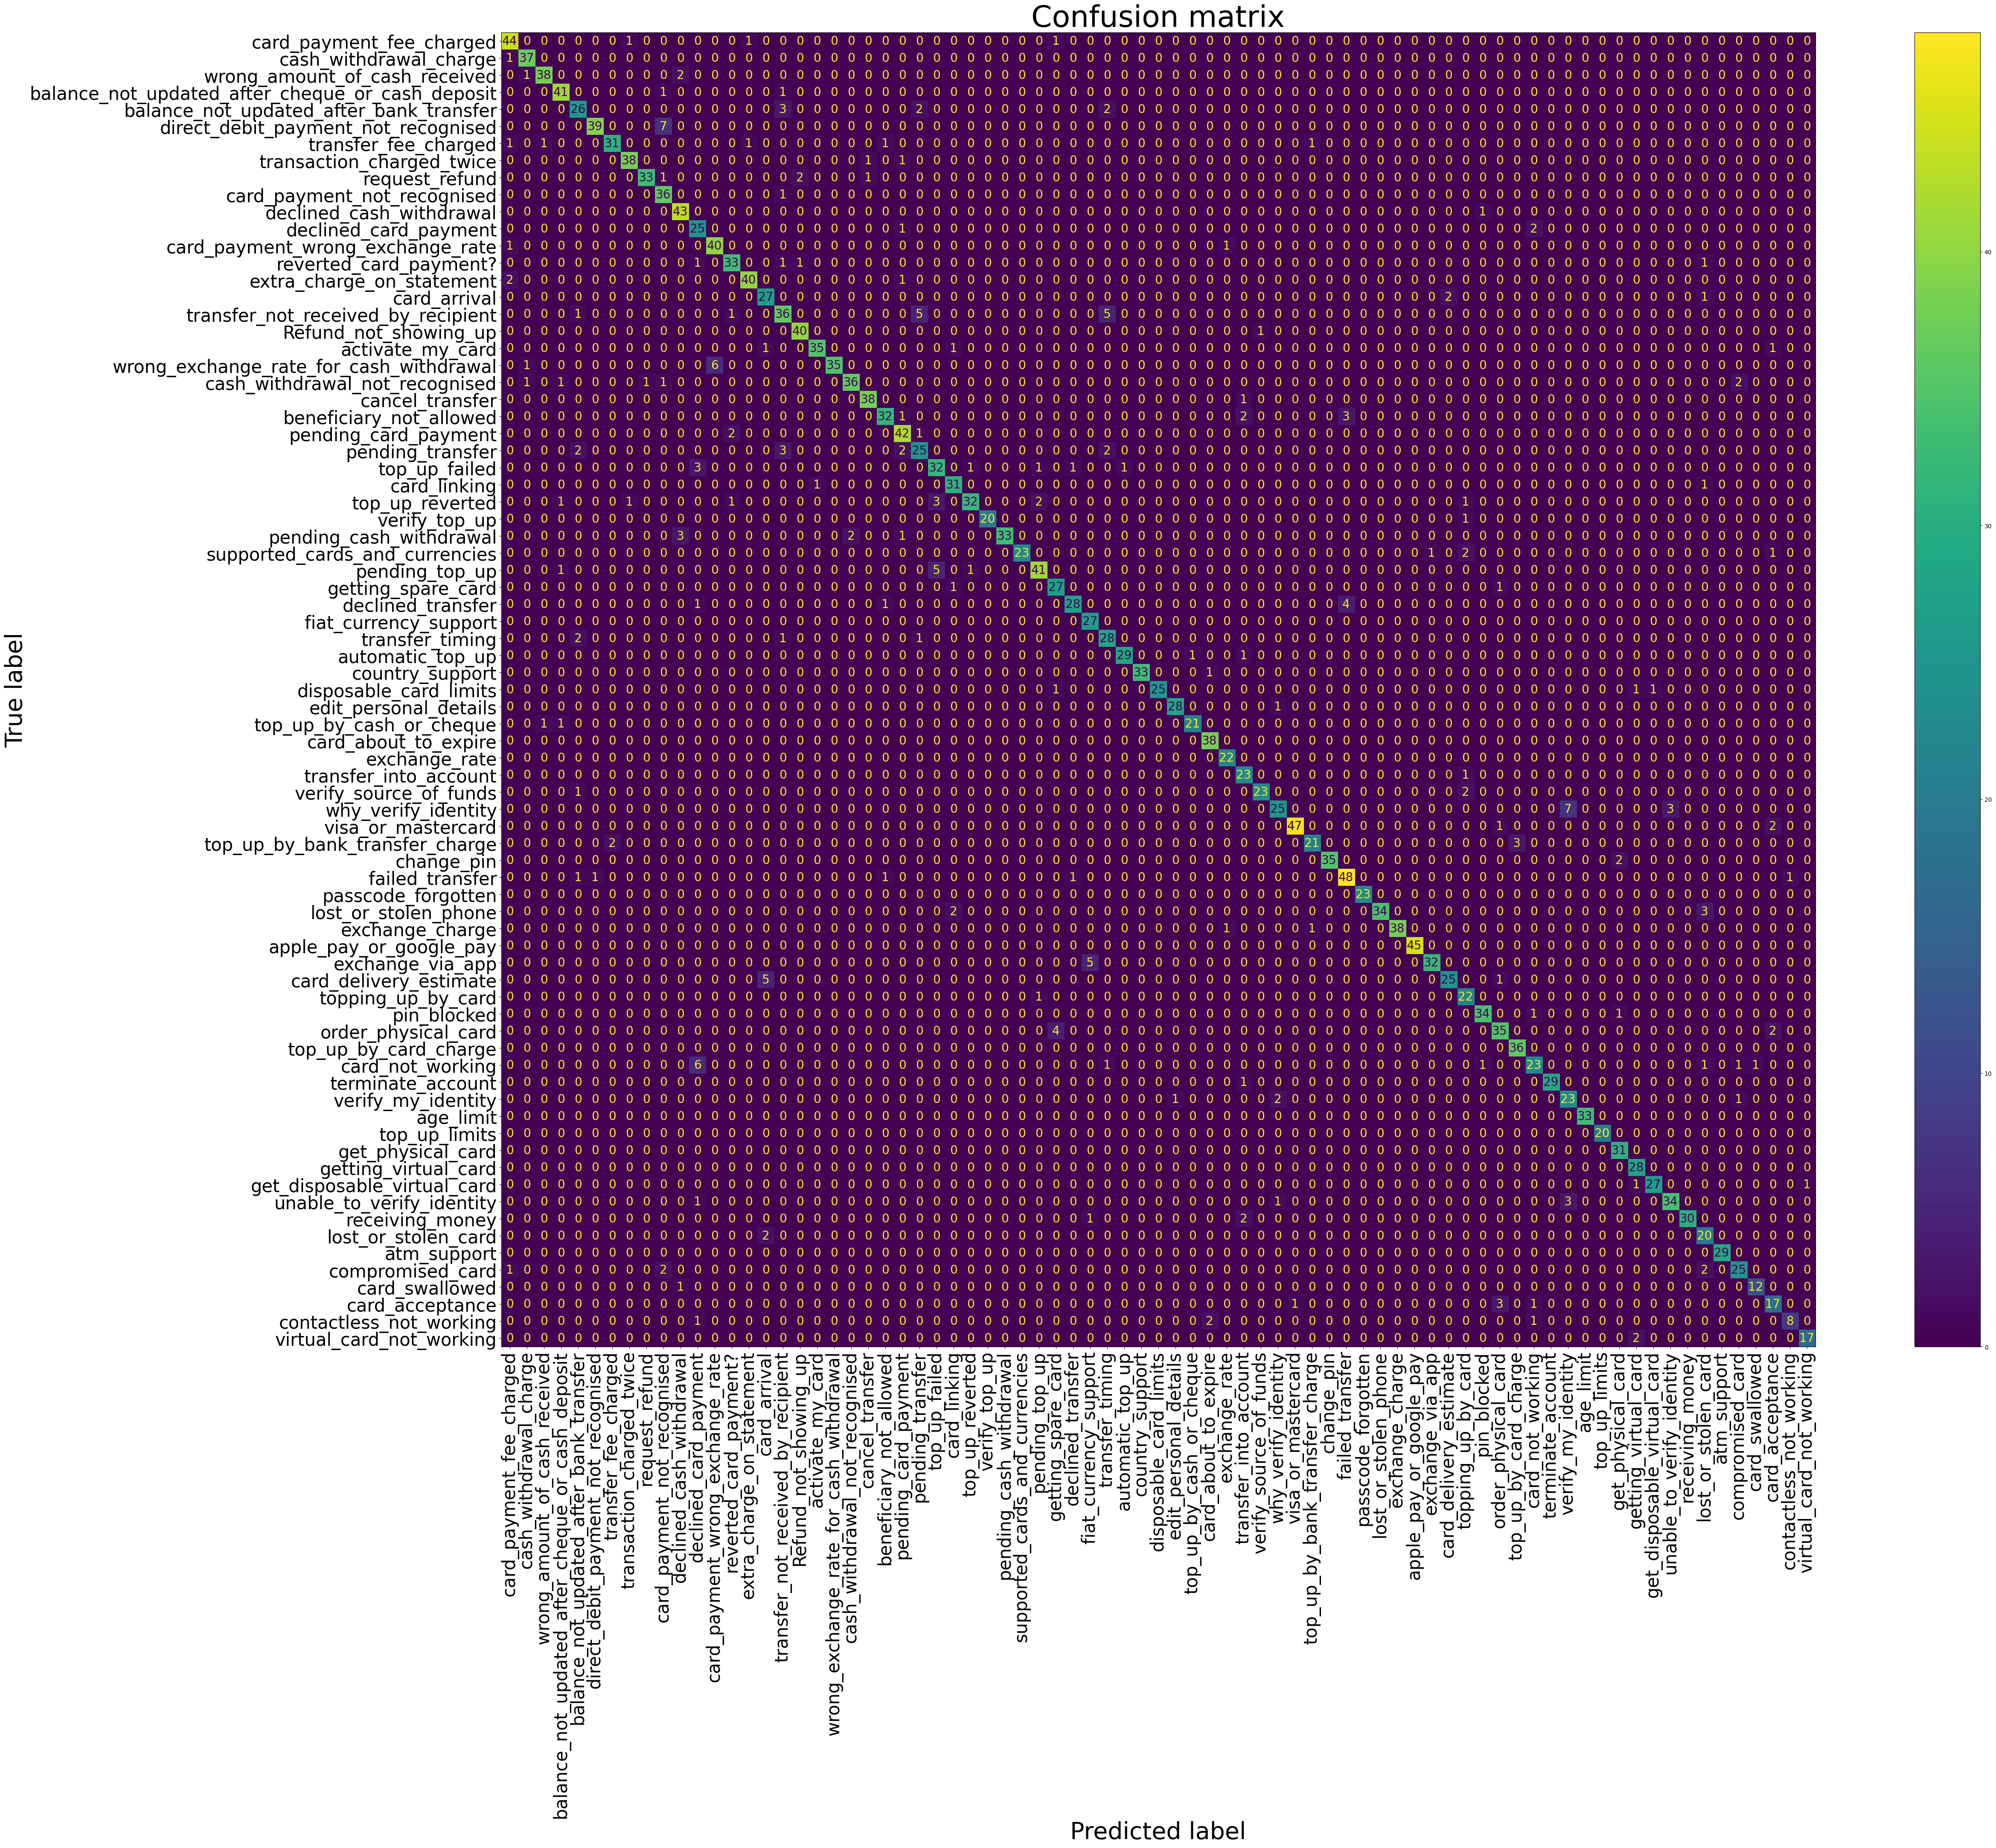

time: 5.56 s (started: 2023-01-24 19:51:49 -05:00)


In [130]:
fig, ax = plt.subplots(figsize=(60, 40))
disp.plot(ax=ax, xticks_rotation='vertical')

for labels in disp.text_.ravel():
    labels.set_fontsize(20)

ax.set_title('Confusion matrix', fontsize=50)
ax.set_ylabel('True label', fontsize=40)
ax.set_xlabel('Predicted label', fontsize=40)

plt.yticks(fontsize=30)
plt.xticks(fontsize=30)